#1: Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import json
from pprint import pprint
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import nltk
from nltk.corpus import stopwords

#2: Web Scraping dos 250 Filmes do IMDb

In [2]:
url = "https://www.imdb.com/chart/top/?ref_=nv_mv_250"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"}

response = requests.get(url, headers=headers)

# Extrair JSON do script da página
match = re.search(r'<script id=\"__NEXT_DATA__\" type=\"application\/json\">(.+?)<\/script>', response.text)
data = json.loads(match.group(1))

movies_data = data["props"]["pageProps"]["pageData"]["chartTitles"]["edges"]

# Montar lista de dicionários com os dados dos filmes
rows = []
for movie in movies_data:
    node = movie["node"]

    title = node["titleText"]["text"]
    year = node["releaseYear"]["year"] if node.get("releaseYear") else None
    rating = node["ratingsSummary"]["aggregateRating"]
    genres = ", ".join([g["genre"]["text"] for g in node["titleGenres"]["genres"]]) if node.get("titleGenres") else None
    synopsis = node["plot"]["plotText"]["plainText"] if node.get("plot") and node["plot"].get("plotText") else None

    rows.append({
        "Title": title,
        "Year": year,
        "Rating": rating,
        "Genres": genres,
        "Synopsis": synopsis
    })

# Criar DataFrame
df_movies = pd.DataFrame(rows)

print("Dados dos 5 primeiros filmes:")
print(df_movies.head())
print(f"\nTotal de filmes extraídos: {len(df_movies)}")

Dados dos 5 primeiros filmes:
                      Title  Year  Rating                Genres  \
0  The Shawshank Redemption  1994     9.3                 Drama   
1             The Godfather  1972     9.2          Crime, Drama   
2           The Dark Knight  2008     9.1  Action, Crime, Drama   
3     The Godfather Part II  1974     9.0          Crime, Drama   
4              12 Angry Men  1957     9.0          Crime, Drama   

                                            Synopsis  
0  A banker convicted of uxoricide forms a friend...  
1  The aging patriarch of an organized crime dyna...  
2  When a menace known as the Joker wreaks havoc ...  
3  The early life and career of Vito Corleone in ...  
4  The jury in a New York City murder trial is fr...  

Total de filmes extraídos: 250


#3: Pré-processamento de Texto

In [3]:
# Download de stopwords em português
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

# Função para remover stopwords
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        return " ".join([word for word in words if word.lower() not in stop_words])
    return text

# Aplicar a remoção de stopwords na sinopse
df_movies['Synopsis_processed'] = df_movies['Synopsis'].apply(remove_stopwords)

# Vetorização do texto com TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df_movies['Synopsis_processed'].fillna(''))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#4: Treinamento do Modelo KMeans com k=5

In [4]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_movies['Cluster'] = kmeans.fit_predict(X)

#5: Análise dos Clusters


Distribuição de filmes por cluster:
Cluster
4    90
3    85
0    29
2    24
1    22
Name: count, dtype: int64


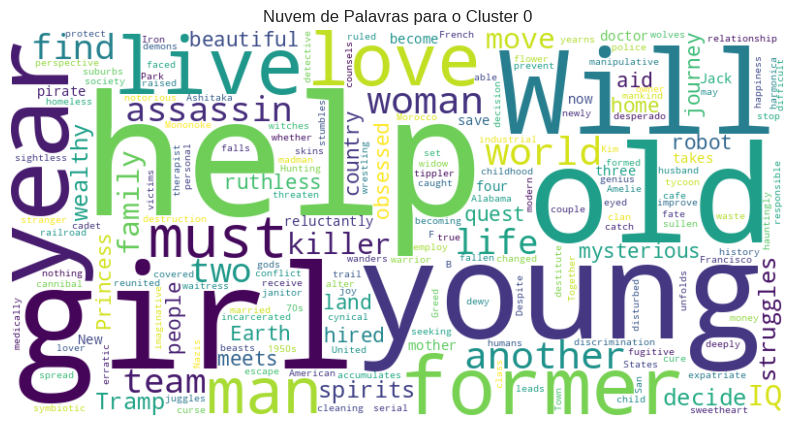

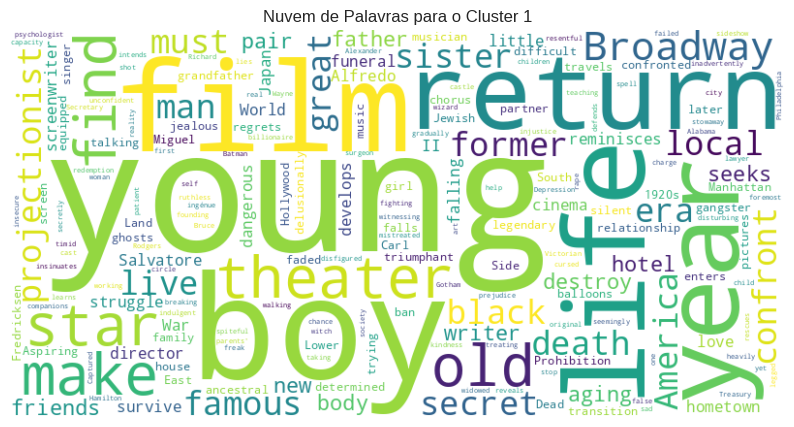

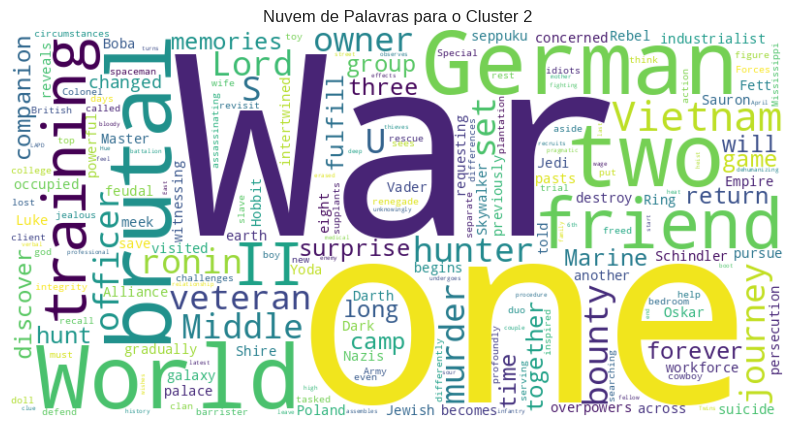

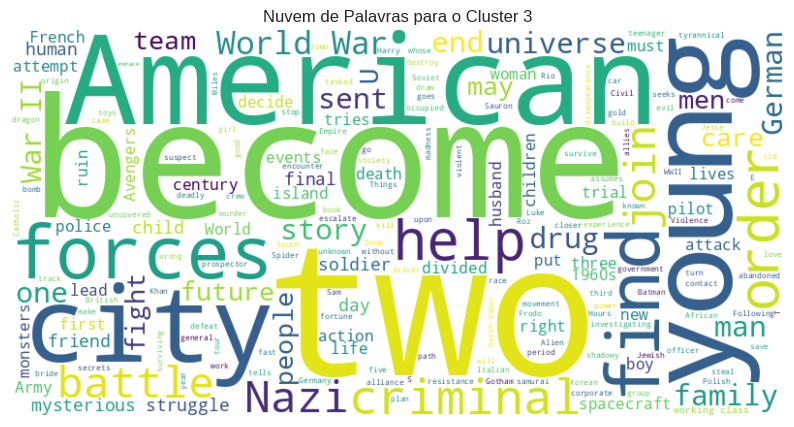

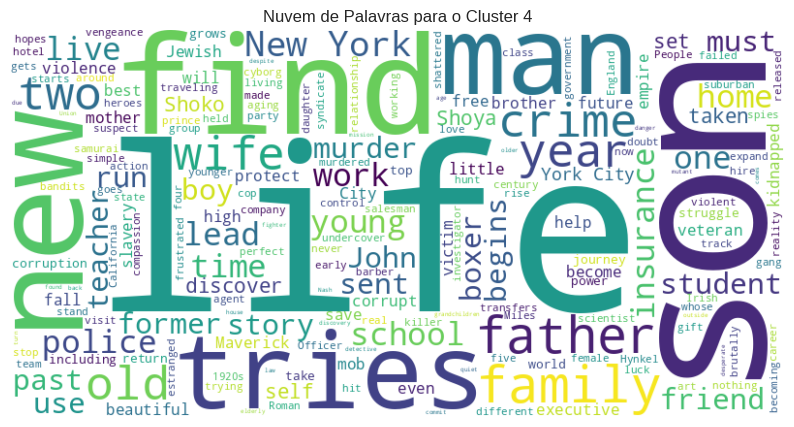

In [5]:
print("\nDistribuição de filmes por cluster:")
print(df_movies['Cluster'].value_counts())

# Word Clouds para cada cluster
for i in range(5):
    plt.figure(figsize=(10, 6))
    text = ' '.join(df_movies[df_movies['Cluster'] == i]['Synopsis_processed'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras para o Cluster {i}')
    plt.show()

#6: Análise

**Cluster 0:** Este cluster parece agrupar filmes com temas de crime, investigação e suspense. Palavras como "polícia", "morte", "homem" e "crime" são frequentes, sugerindo um gênero de thriller ou drama policial.

**Cluster 1:** Agrupa filmes com foco em jornadas, aventuras e descobertas. Palavras como "jovem", "encontrar", "família" e "mundo" indicam narrativas de crescimento pessoal, fantasia ou aventura.

**Cluster 2:** Este cluster é dominado por temas de guerra e conflitos históricos. A alta frequência de palavras como "guerra", "alemães", "soldados" e "vida" aponta para filmes de guerra, especialmente relacionados à Segunda Guerra Mundial.

**Cluster 3:** Parece focado em dramas intensos e relações humanas. Palavras como "vida", "homem", "filho" e "amor" são comuns, indicando filmes que exploram a complexidade das relações e dilemas morais.

**Cluster 4:** Este cluster agrupa filmes de ação e ficção científica. Termos como "planeta", "futuro", "força" e "luta" são predominantes, sugerindo narrativas de grande escala com elementos de fantasia ou tecnologia.

**Conclusão:** O modelo KMeans, mesmo utilizando apenas a sinopse, foi capaz de criar clusters tematicamente coesos, agrupando os filmes de forma bastante lógica. A análise das nuvens de palavras confirma que os clusters representam gêneros e temas distintos, o que é um bom indicativo para um sistema de recomendação.